## Threshold Detection


### Import Packages

In [1]:
import os
import sys
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import geopandas as gpd
import torch.optim as optim
import matplotlib.pyplot as plt

plt.style.use("~/geoscience/carbon_estimation/MNRAS.mplstyle")
%matplotlib inline

## GEDI

### Loading Data

In [2]:
# all_cols = ["date", "shot_number", "BEAM_l2a", "Latitude_l2a", "Longitude_l2a", 
#             "quality_flag", "num_detectedmodes", "rh_90", "rh_95", "rh_98", "rh_99", 
#             "rh_100", "sensitivity", "solar_elevation", "geometry_l2a", "Easting_l2a", 
#             "Northing_l2a", "elevation_NAVD88_gedi_from_crs_l2a", "GEDI02_A_slope_ratio_utm", 
#             "GEDI02_A_slope_degrees_utm", "GEDI02_A_slope_rise_run", "rx_sample_count", "cover_z_10", 
#             "cover_z_15", "cover_z_20", "cover_z_25", "cover_z_27", "cover_z_28", "cover_z_29", 
#             "fhd_normal", "pai_z_10", "pai_z_15", "pai_z_20", "pai_z_25", "pai_z_27", "pai_z_28", 
#             "pai_z_29", "pavd_z_10", "pavd_z_15", "pavd_z_20", "pavd_z_25", "pavd_z_27", "pavd_z_28", "pavd_z_29", "rh100"]

drop_cols = ["date", "BEAM_l2a", "shot_number", "Latitude_l2a", "Longitude_l2a", 
             "rh_90", "rh_95", "rh_98", "rh_99", "GEDI02_A_slope_ratio_utm", 
             "GEDI02_A_slope_rise_run", "cover_z_10", "cover_z_15", "cover_z_20", 
             "cover_z_25", "cover_z_27", "cover_z_28", "pai_z_10", "pai_z_15", 
             "pai_z_20", "pai_z_25", "pai_z_27", "pai_z_28", "pavd_z_10", 
             "pavd_z_15", "pavd_z_20", "pavd_z_25", "pavd_z_27", "pavd_z_28", "rh100", "geometry"]

# drop = ["elevation_NAVD88_gedi_from_pipe_l2a", "elevation_l2a", "degrade_flag", "quality_flag", "rhog", "rhov"]

In [3]:
gedi_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/gedi_data/gedi_finder/ml_data/"
gedi_file = "gedi_ml_detection_threshold.geojson"
# Show rows where data is missing
pd.set_option("display.max_columns", None)
gedi_data = gpd.read_file(os.path.join(gedi_dir, gedi_file))
# gedi_data = gedi_data.drop(drop_cols, axis = 1)
# gedi_data = gedi_data[gedi_data["fhd_normal"] != -9999.000000]
gedi_data.head()

ERROR 1: PROJ: proj_create_from_database: Open of /bsuscratch/tnde/miniforge3/envs/veg_height/share/proj failed
/bsuscratch/tnde/miniforge3/envs/veg_height/lib/python3.10/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


,date,shot_number,BEAM_l2a,Latitude_l2a,Longitude_l2a,quality_flag,num_detectedmodes,rh_30,rh_40,rh_50,rh_60,rh_70,rh_71,rh_72,rh_73,rh_74,rh_75,rh_76,rh_77,rh_78,rh_79,rh_80,rh_81,rh_82,rh_83,rh_84,rh_85,rh_86,rh_87,rh_88,rh_89,rh_90,rh_91,rh_92,rh_93,rh_94,rh_95,rh_96,rh_97,rh_98,rh_99,rh_100,sensitivity,solar_elevation,Easting_l2a,Northing_l2a,elevation_NAVD88_gedi_from_crs_l2a,GEDI02_A_slope_ratio_utm,GEDI02_A_slope_degrees_utm,GEDI02_A_slope_rise_run,rx_sample_count,cover_z_10,cover_z_15,cover_z_20,cover_z_25,cover_z_27,cover_z_28,cover_z_29,fhd_normal,pai_z_10,pai_z_15,pai_z_20,pai_z_25,pai_z_27,pai_z_28,pai_z_29,pavd_z_10,pavd_z_15,pavd_z_20,pavd_z_25,pavd_z_27,pavd_z_28,pavd_z_29,rh100,degrade_flag,stale_return_flag,geometry
0,2019-07-23 02:29:57,34511100200281473,BEAM1011,43.309238,-116.831206,1,1,-0.93,-0.52,-0.14,0.22,0.63,0.67,0.71,0.74,0.78,0.86,0.89,0.93,0.97,1.04,1.08,1.12,1.19,1.23,1.31,1.34,1.42,1.49,1.53,1.61,1.68,1.79,1.87,1.98,2.09,2.21,2.36,2.51,2.73,3.10,4.04,0.976120,1.137563,513688.964915,4.795170e+06,1815.427281,0.017394,0.996506,0.001113,755.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.417535,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,403,0,0.0,POINT (513688.965 4795169.966)
1,2019-07-23 02:29:57,34511100200281474,BEAM1011,43.309520,-116.830618,1,1,-0.93,-0.52,-0.18,0.18,0.52,0.56,0.59,0.67,0.71,0.74,0.78,0.82,0.86,0.89,0.97,1.01,1.04,1.08,1.16,1.19,1.27,1.31,1.38,1.46,1.49,1.57,1.68,1.76,1.83,1.94,2.09,2.24,2.43,2.73,3.63,0.975038,1.137287,513736.570004,4.795201e+06,1815.428389,0.000019,0.001113,-1.034706,749.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.340707,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,363,0,0.0,POINT (513736.57 4795201.316)
2,2019-07-23 02:29:57,34511100200281475,BEAM1011,43.309801,-116.830030,1,1,-1.01,-0.56,-0.18,0.22,0.63,0.67,0.71,0.78,0.82,0.86,0.93,0.97,1.01,1.08,1.12,1.19,1.23,1.31,1.34,1.42,1.49,1.57,1.64,1.72,1.79,1.91,2.02,2.13,2.24,2.43,2.62,2.84,3.14,3.67,4.90,0.976903,1.137010,513784.205063,4.795233e+06,1814.398598,-0.018061,-1.034706,-1.132363,766.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.658798,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,490,0,0.0,POINT (513784.205 4795232.651)
3,2019-07-23 02:29:57,34511100200281476,BEAM1011,43.310082,-116.829441,1,1,-0.86,-0.48,-0.14,0.18,0.52,0.56,0.59,0.63,0.67,0.71,0.74,0.78,0.82,0.89,0.93,0.97,1.01,1.04,1.12,1.16,1.23,1.27,1.34,1.42,1.46,1.53,1.61,1.72,1.79,1.91,2.06,2.21,2.39,2.69,3.59,0.971373,1.136734,513831.832065,4.795264e+06,1813.271707,-0.019766,-1.132363,0.001117,745.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.269725,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,358,0,0.0,POINT (513831.832 4795263.988)
4,2019-07-23 02:29:57,34511100200281477,BEAM1011,43.310364,-116.828854,1,1,-0.86,-0.48,-0.14,0.14,0.52,0.52,0.56,0.59,0.63,0.67,0.74,0.78,0.82,0.86,0.89,0.93,0.97,1.04,1.08,1.12,1.19,1.23,1.31,1.34,1.42,1.49,1.57,1.64,1.76,1.83,1.94,2.09,2.28,2.58,3.37,0.973743,1.136458,513879.447137,4.795295e+06,1813.272818,0.000019,0.001117,-2.100310,745.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.790818,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,-0.0,336,0,0.0,POINT (513879.447 4795295.327)


Length of data 12162
Minimum veg. height 0.03


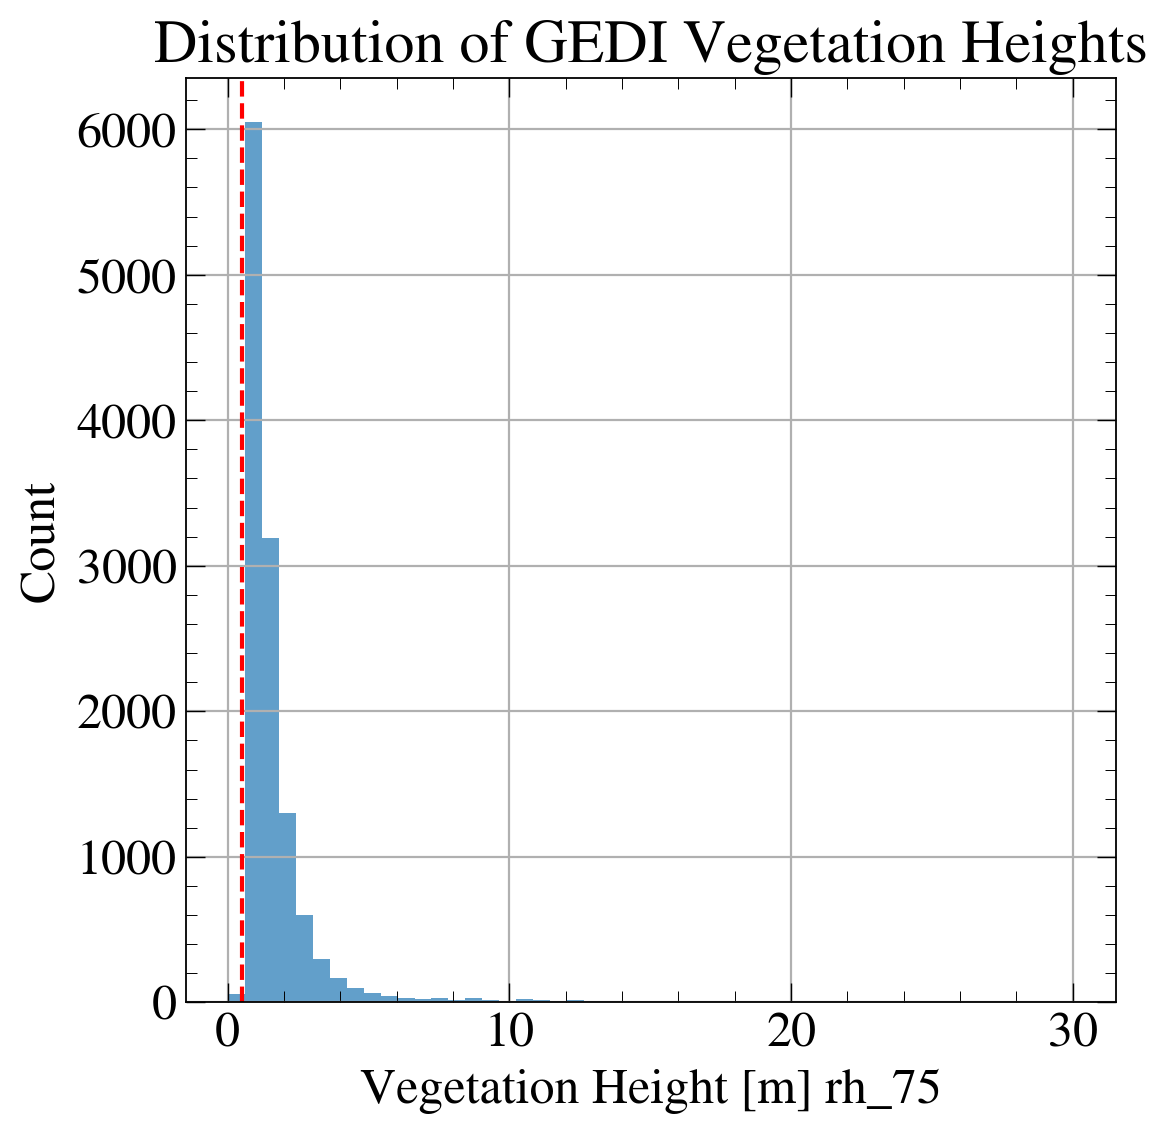

In [4]:
good_quality = gedi_data[
    (gedi_data["quality_flag"] == 1) &
    (gedi_data["degrade_flag"] == 0) &
    (gedi_data["sensitivity"] >= 0.80)
]

f = "rh_75"
print("Length of data", len(good_quality[f]))
print("Minimum veg. height", np.min(good_quality[f]))
plt.hist(good_quality[f"{f}"], bins=50, alpha=0.7)
plt.axvline(x=0.5, color="r", linestyle='--', label="0.5m Threshold")
# plt.xlabel("Vegetation Height (RH98) [m]")
plt.xlabel(f"Vegetation Height [m] {f}")
plt.ylabel("Count")
# plt.legend()
plt.title(f"Distribution of GEDI Vegetation Heights")
plt.show()

rh_100: length = 12162, min = 2.82
rh_90: length = 12162, min = 1.38
rh_80: length = 12162, min = 0.44


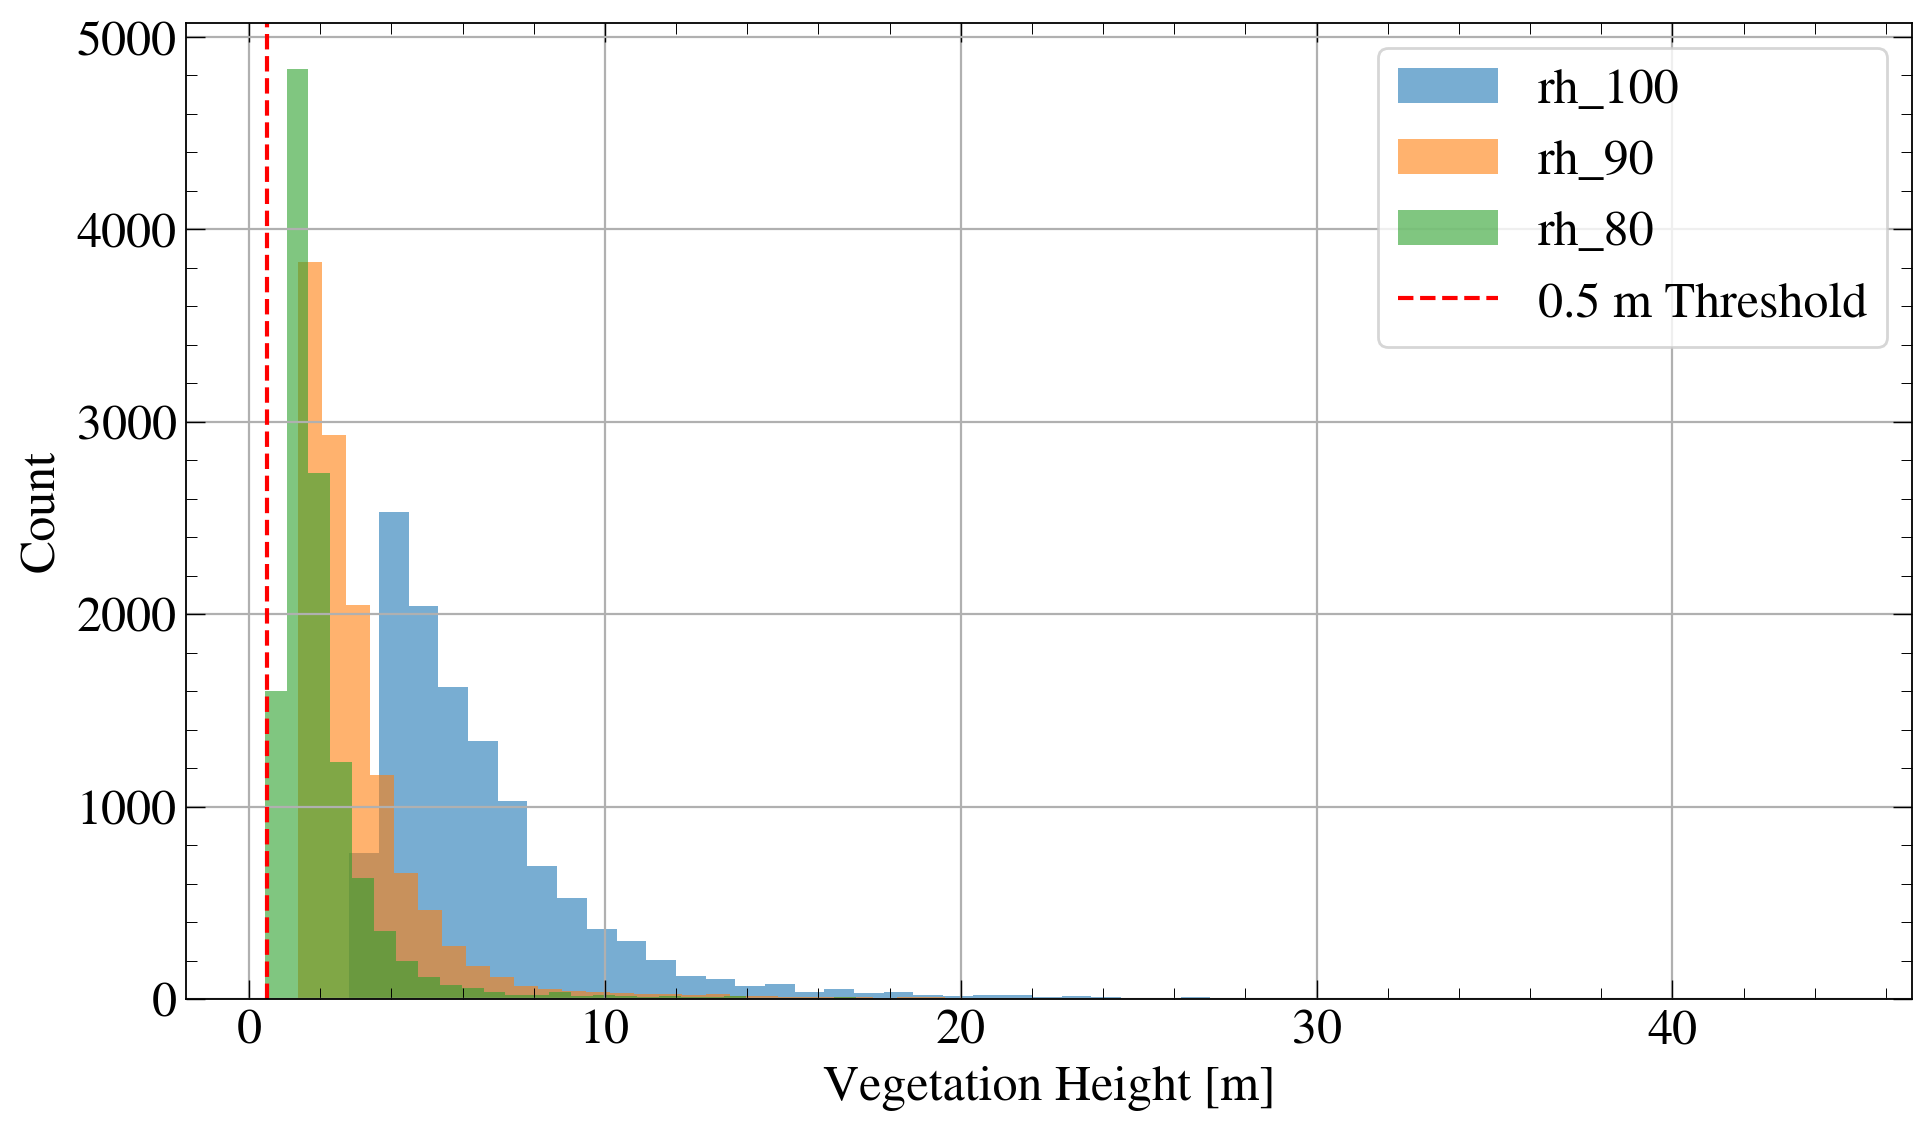

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# List of RH metrics to plot
rh_metrics = ["rh_100", "rh_90", "rh_80"]

plt.figure(figsize=(10, 6))

# Plot each RH metric
for rh in rh_metrics:
    print(f"{rh}: length = {len(good_quality[rh])}, min = {np.min(good_quality[rh])}")
    plt.hist(good_quality[rh], bins=50, alpha=0.6, label=f"{rh}")#, edgecolor="black")

# vertical threshold line
plt.axvline(x=0.5, color="r", linestyle='--', label="0.5 m Threshold")

plt.xlabel("Vegetation Height [m]")
plt.ylabel("Count")
# plt.title("Distribution of GEDI Vegetation Heights (RH Metrics)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

rh_100: length = 12162, min = 2.82
rh_90: length = 12162, min = 1.38
rh_80: length = 12162, min = 0.44


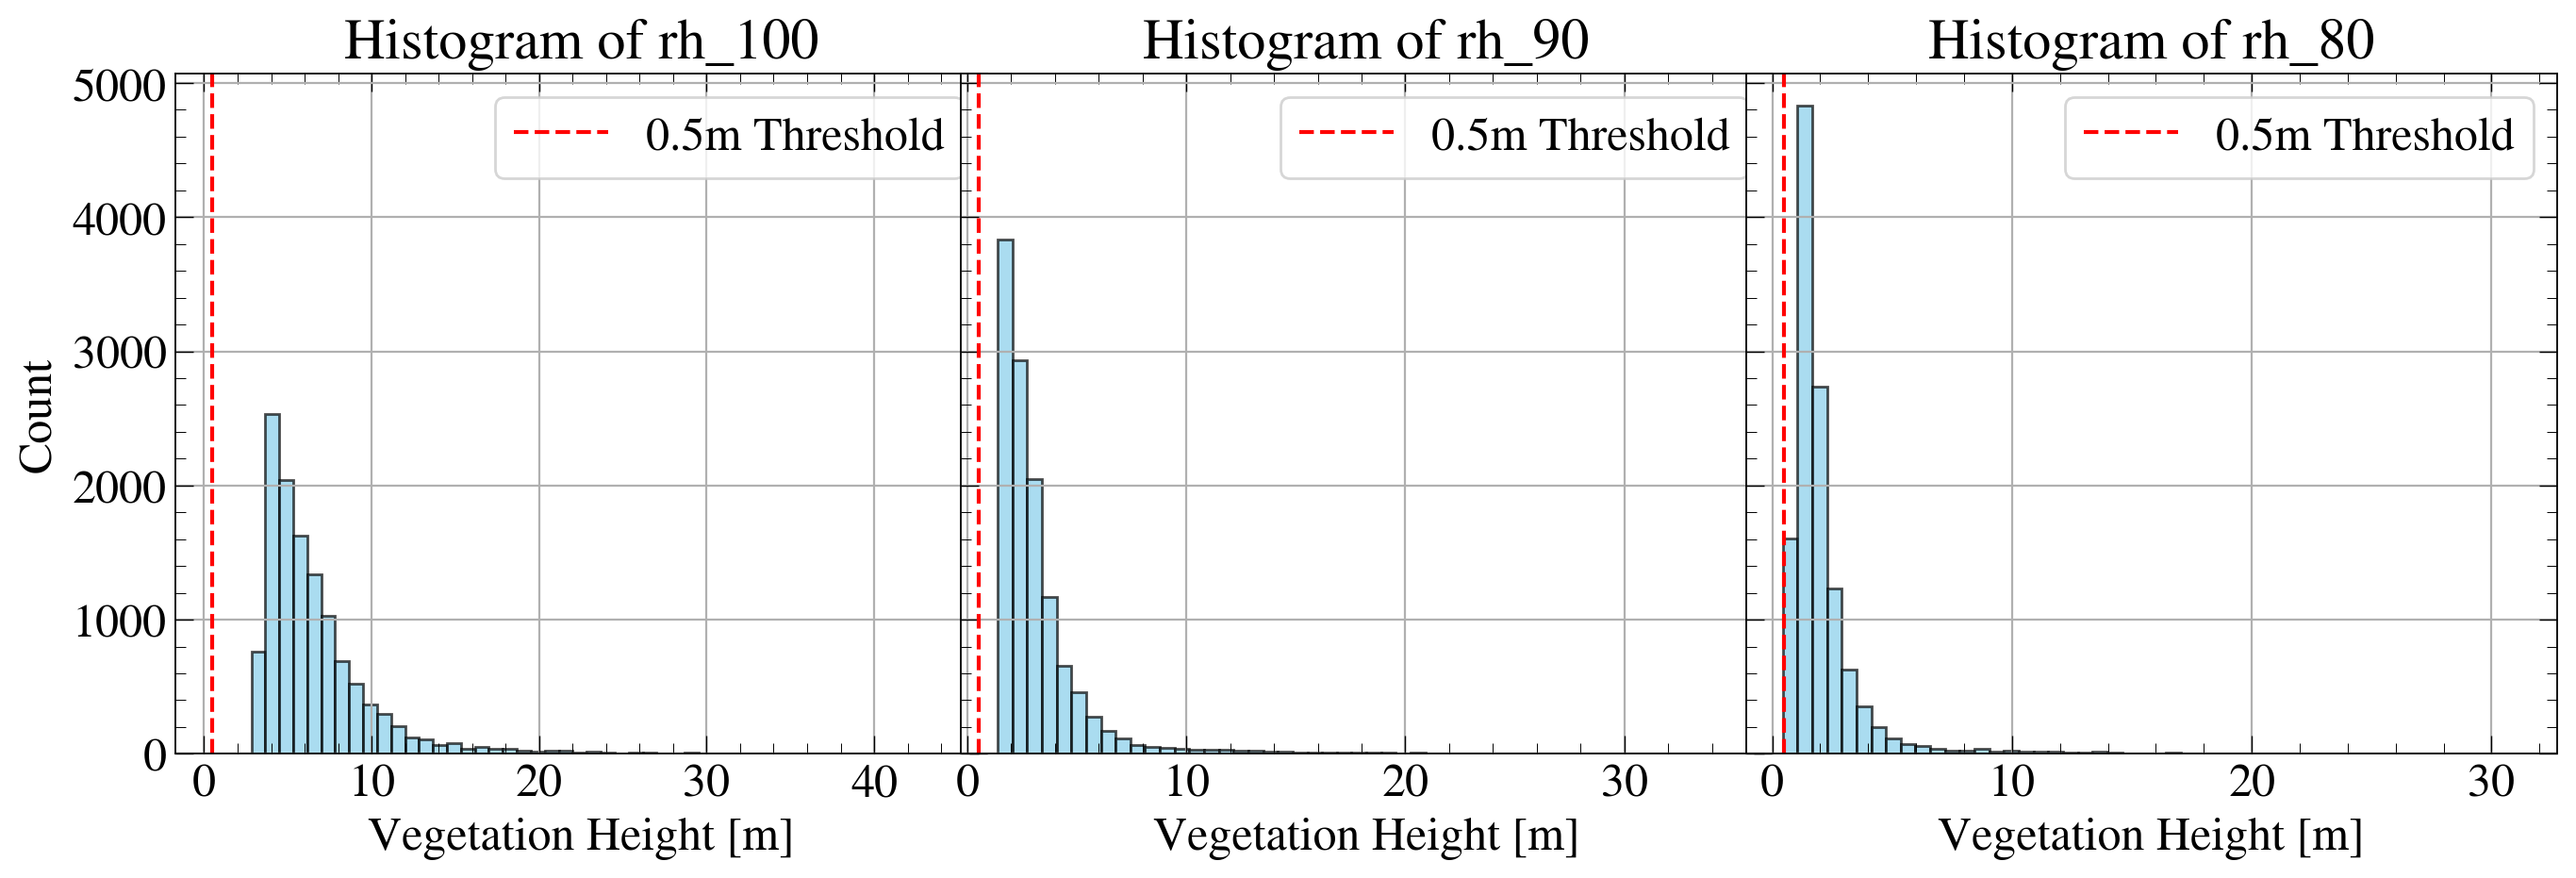

In [6]:
# RH metrics to plot
rh_metrics = ["rh_100", "rh_90", "rh_80"]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(14, 5), sharey=True)

# Loop through RH metrics and axes
for ax, rh in zip(axes, rh_metrics):
    print(f"{rh}: length = {len(good_quality[rh])}, min = {np.min(good_quality[rh])}")
    ax.hist(good_quality[rh], bins=50, alpha=0.7, color="skyblue", edgecolor="black")
    ax.axvline(x=0.5, color="red", linestyle='--', label="0.5m Threshold")
    ax.set_title(f"Histogram of {rh}")
    ax.set_xlabel("Vegetation Height [m]")
    ax.legend()
    
# Set shared y-label
axes[0].set_ylabel("Count")

plt.tight_layout(h_pad=-1.0, w_pad=-0.7)
plt.show()


Length of data 12162
Minimum veg. height 0.89


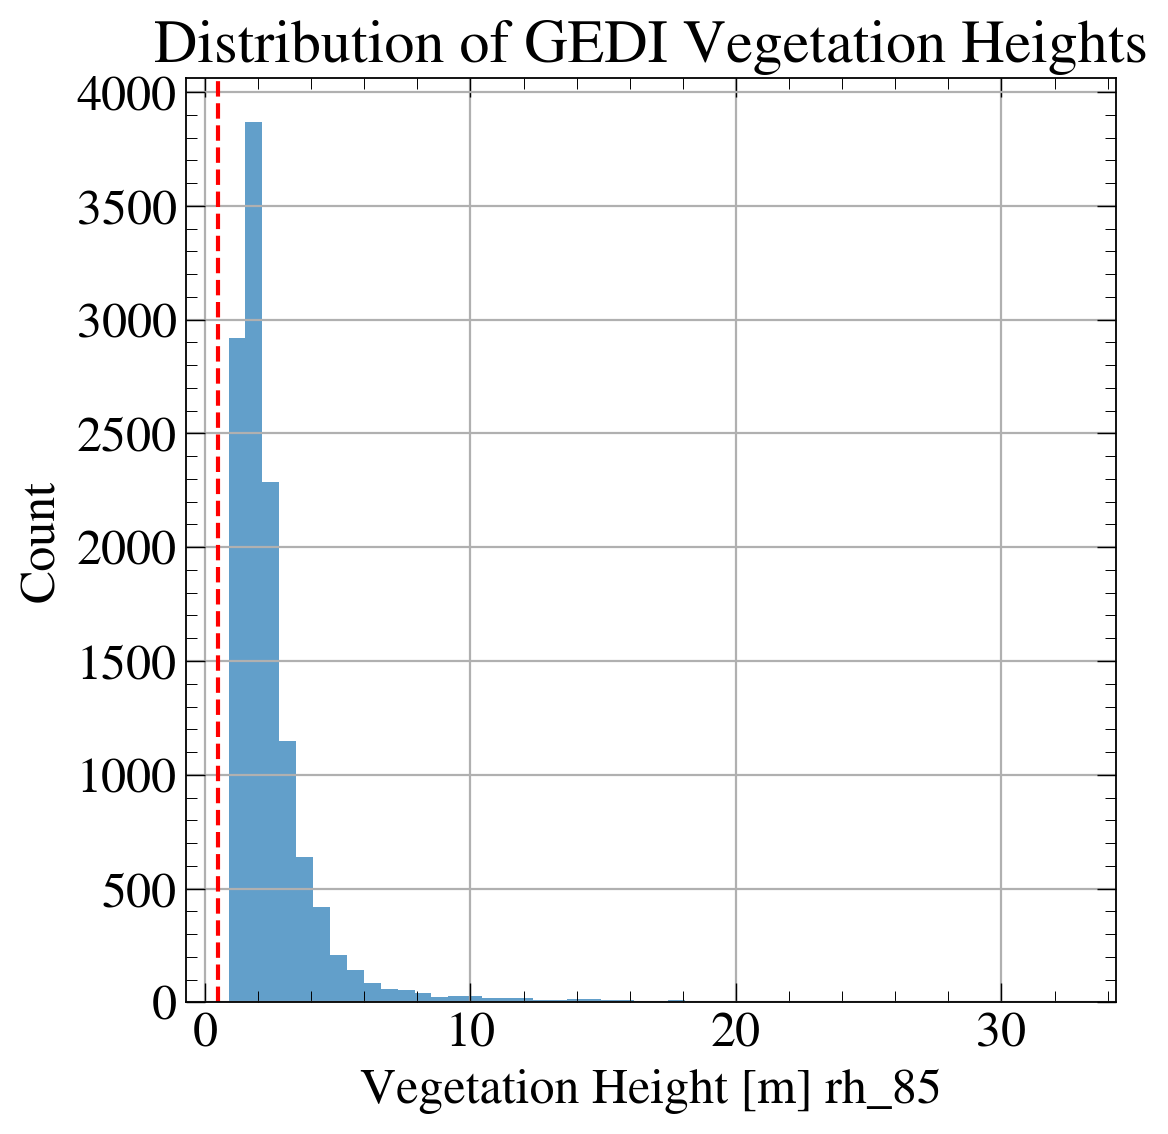

In [7]:
f = "rh_85"

high_confidence_forest = good_quality[
    (good_quality[f] >= 0) &
    (good_quality["sensitivity"] >= 0.70)
]

print("Length of data", len(high_confidence_forest[f]))
print("Minimum veg. height", np.min(high_confidence_forest[f]))
plt.hist(high_confidence_forest[f"{f}"], bins=50, alpha=0.7)
plt.axvline(x=0.5, color="r", linestyle='--', label="0.5m Threshold")
# plt.xlabel("Vegetation Height (RH98) [m]")
plt.xlabel(f"Vegetation Height [m] {f}")
plt.ylabel("Count")
# plt.legend()
plt.title(f"Distribution of GEDI Vegetation Heights")
plt.show()

## ICESat-2

### Loading Data

In [84]:
function_path = os.path.expanduser("~/geoscience/carbon_estimation/code/functions")
sys.path.append(function_path)

In [85]:
%%time
from helper_functions import load_icesat2_data
# Projected CRS
projected_crs = "epsg:6340"  
icesat2_dir = "/bsuhome/tnde/scratch/carbon_estimation/data/icesat2_data/" 
atl08 = icesat2_dir+f'{"rcew_icesat2_atl08_all_new_final.geojson"}'
icesat2_gdf_atl08 = load_icesat2_data(atl08, "ATL08", process = True)
print(icesat2_gdf_atl08.crs, "\n")
icesat2_gdf_atl08.crs

EPSG:6340 

CPU times: user 4.12 s, sys: 249 ms, total: 4.37 s
Wall time: 18.6 s


/bsuscratch/tnde/miniforge3/envs/veg_height/lib/python3.10/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/bsuscratch/tnde/miniforge3/envs/veg_height/lib/python3.10/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)
/bsuscratch/tnde/miniforge3/envs/veg_height/lib/python3.10/site-packages/pyogrio/geopandas.py:49: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  res = pd.to_datetime(ser, **datetime_kwargs)


<Projected CRS: EPSG:6340>
Name: NAD83(2011) / UTM zone 11N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United States (USA) - between 120°W and 114°W onshore and offshore - California, Idaho, Nevada, Oregon, Washington.
- bounds: (-120.0, 30.88, -114.0, 49.01)
Coordinate Operation:
- name: UTM zone 11N
- method: Transverse Mercator
Datum: NAD83 (National Spatial Reference System 2011)
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [88]:
icesat2_gdf_atl08.columns

Index(['time', 'x_atc', 'h_min_canopy', 'h_te_median', 'gt', 'spot', 'rgt',
       'gnd_ph_count', 'h_mean_canopy', 'h_canopy', 'h_max_canopy',
       'snowcover', 'ph_count', 'canopy_h_metrics', 'solar_elevation_x',
       'segment_id', 'veg_ph_count', 'landcover', 'extent_id',
       'canopy_openness', 'cycle', 'num_bins', 'binsize', 'waveform',
       'pce_mframe_cnt', 'solar_elevation_y', 'h_dif_ref', 'Longitude',
       'Latitude', 'Easting', 'Northing', 'elevation_NAVD88_icesat2_from_pipe',
       'elevation_NAVD88_icesat2_from_crs', 'Date', 'date', 'geometry'],
      dtype='object')